In [968]:
# Library imports

from __future__ import annotations

from dataclasses import dataclass, asdict
from pathlib import Path
import hashlib
import json
import numpy as np
import pandas as pd
import pyarrow.dataset as ps
import glob
import os
import matplotlib.pyplot as plt
import random
import time
import math
import logging
import itertools

from openpyxl import load_workbook
import xlsxwriter as xw

In [969]:
@dataclass
class CommunityProfile:
    name: str
    load_profile: pd.DataFrame

In [970]:
start_time = time.time()

In [971]:
# Define the file pattern to search for the RESSTOCK *.Parquet files
DATA_DIR = "../data/"

# Define input data directories
INPUT_DATA_DIR = os.path.join(DATA_DIR, "input/")

# RESSTOCK directories
INPUT_DATA_DIR_RESSTOCK = os.path.join(INPUT_DATA_DIR, "resstock/")
INPUT_DATA_DIR_RESSTOCK_BUILDINGPROFILES = os.path.join(INPUT_DATA_DIR_RESSTOCK, "timeseries_individual_buildings/")

# Define output data directories

OUTPUT_DATA_DIR = os.path.join(DATA_DIR, "output/")
OUTPUT_DATA_DIR_SCENARIO_RUNS = os.path.join(OUTPUT_DATA_DIR, "scenario_runs/")

In [972]:
# COMMSTOCK directories
INPUT_DATA_DIR_COMSTOCK = os.path.join(INPUT_DATA_DIR, "comstock/")
INPUT_DATA_DIR_COMSTOCK_BUILDINGPROFILES = os.path.join(INPUT_DATA_DIR_COMSTOCK, "timeseries_individual_buildings/")

In [973]:
# "0" is baseline scenario
UPGRADE_NUM = "0"

# Washington, DC
STATE = "DC"

file_pattern = os.path.join(INPUT_DATA_DIR_RESSTOCK_BUILDINGPROFILES, f"upgrade={UPGRADE_NUM}/state={STATE}/", "*.parquet")

# Get a list of all file names matching the pattern
all_files = glob.glob(file_pattern, recursive=True)

print(f"Total RESSTOCK files found: {all_files}")

Total RESSTOCK files found: ['../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/206093-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/79081-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/541915-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/130440-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/89323-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/371093-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/398150-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/518977-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/86497-0.parquet', '../data/input/resstock/timeseries_individual_buildings/upgrade=0/state=DC/77991-0.parquet', '../data/input/resstock/timeseries_

In [974]:
RESSTOCK_BUILDING_CHARACTERISTICS_FILE = 'DC_upgrade0.xlsx'
RESSTOCK_BUILDING_CHARACTERISTICS_FILEPATH = DATA_DIR + 'background/' + RESSTOCK_BUILDING_CHARACTERISTICS_FILE
building_characteristics = pd.read_excel(RESSTOCK_BUILDING_CHARACTERISTICS_FILEPATH, sheet_name='building_characteristics')


In [975]:
## Build the neighborhood

TOTAL_BUILDINGS = 100 # could be adjusted or varied for additional analysis of different community sizes and their ability to utilize a microgrid

MULTIFAMILY_BUILDINGS_PERCENT_OF_TOTAL = 0.20
SINGLEFAMILY_ATTACHED_BUILDINGS_PERCENT_OF_TOTAL = 0.50
SINGLEFAMILY_DETACHED_BUILDINGS_PERCENT_OF_TOTAL = 0.30

if MULTIFAMILY_BUILDINGS_PERCENT_OF_TOTAL + SINGLEFAMILY_ATTACHED_BUILDINGS_PERCENT_OF_TOTAL + SINGLEFAMILY_DETACHED_BUILDINGS_PERCENT_OF_TOTAL != 1.0:
    raise ValueError("The sum of building type percentages must equal 1.0")

MULTIFAMILY_BUILDINGS = {
    "PERCENT_OF_TOTAL": MULTIFAMILY_BUILDINGS_PERCENT_OF_TOTAL,
    "SMALL": {
        "NAME" : ["Multi-Family with 2 - 4 Units", "Multi-Family with 5+ Units, 1-3 Stories"],
        "MULTIFAMILY_BUILDINGS_SMALL_PERCENT_OF_TOTAL": 1.0,
    },
    "MID" : {
        "NAME" : ["Multi-Family with 5+ Units, 4-7 Stories",],
        "MULTIFAMILY_BUILDINGS_MID_PERCENT_OF_TOTAL": 0.0,
    },
    "LARGE" : { 
        "NAME" : ["Multi-Family with 5+ Units, 8+ Stories",],
        "MULTIFAMILY_BUILDINGS_LARGE_PERCENT_OF_TOTAL": 0.0,
    },
}

["Multi-Family with 2 - 4 Units", "Multi-Family with 5+ Units, 1-3 Stories", "Multi-Family with 5+ Units, 4-7 Stories", "Multi-Family with 5+ Units, 8+ Stories"]

SINGLEFAMILY_CHARACTERISTICS = {
    "AREALIMIT": 2000,
    "GARAGE": "None",
    "HEATPUMP": 0.1,
    #"PV": 0.2,
    #"EV": 0.2,
}

SINGLEFAMILY_ATTACHED_BUILDINGS = {
    "NAME": "Single-Family Attached",
    "PERCENT_OF_TOTAL": SINGLEFAMILY_ATTACHED_BUILDINGS_PERCENT_OF_TOTAL,
    "CHARACTERISTICS": SINGLEFAMILY_CHARACTERISTICS,
}
SINGLEFAMILY_DETACHED_BUILDINGS = {
    "NAME" : "Single-Family Detached",
    "PERCENT_OF_TOTAL" : SINGLEFAMILY_DETACHED_BUILDINGS_PERCENT_OF_TOTAL,
    "CHARACTERISTICS": SINGLEFAMILY_CHARACTERISTICS,
}


In [976]:

## construct multifamily

def construct_neighborhood_residential():

    multifamily_small_list = []
    mutlifamily_mid_list = []
    multifamily_large_list = []

    multifamily_small_list.extend(building_characteristics[building_characteristics['in.geometry_building_type_height'] == MULTIFAMILY_BUILDINGS["SMALL"]["NAME"][0]]['bldg_id'].tolist())
    multifamily_small_list.extend(building_characteristics[building_characteristics['in.geometry_building_type_height'] == MULTIFAMILY_BUILDINGS["SMALL"]["NAME"][1]]['bldg_id'].tolist())
    mutlifamily_mid_list.extend(building_characteristics[building_characteristics['in.geometry_building_type_height'] == MULTIFAMILY_BUILDINGS["MID"]["NAME"][0]]['bldg_id'].tolist())
    multifamily_large_list.extend(building_characteristics[building_characteristics['in.geometry_building_type_height'] == MULTIFAMILY_BUILDINGS["LARGE"]["NAME"][0]]['bldg_id'].tolist())

    multifamily_small_chosen = random.choices(multifamily_small_list, k=math.ceil(TOTAL_BUILDINGS * MULTIFAMILY_BUILDINGS["PERCENT_OF_TOTAL"] * MULTIFAMILY_BUILDINGS["SMALL"]["MULTIFAMILY_BUILDINGS_SMALL_PERCENT_OF_TOTAL"]))
    multifamily_mid_chosen = random.choices(mutlifamily_mid_list, k=math.ceil(TOTAL_BUILDINGS * MULTIFAMILY_BUILDINGS["PERCENT_OF_TOTAL"] * MULTIFAMILY_BUILDINGS["MID"]["MULTIFAMILY_BUILDINGS_MID_PERCENT_OF_TOTAL"]))
    multifamily_large_chosen = random.choices(multifamily_large_list, k=math.ceil(TOTAL_BUILDINGS * MULTIFAMILY_BUILDINGS["PERCENT_OF_TOTAL"] * MULTIFAMILY_BUILDINGS["LARGE"]["MULTIFAMILY_BUILDINGS_LARGE_PERCENT_OF_TOTAL"]))

    print(f'Multi-Family Large Chosen: {multifamily_large_chosen}')


    ## construct single family attached and detached

    singlefamily_attached_hp = building_characteristics[building_characteristics['in.geometry_garage'].isnull() 
                                                    & (building_characteristics['in.geometry_building_type_height'] == SINGLEFAMILY_ATTACHED_BUILDINGS["NAME"]) 
                                                    & (building_characteristics['in.sqft..ft2'] <= SINGLEFAMILY_ATTACHED_BUILDINGS["CHARACTERISTICS"]["AREALIMIT"])
                                                    & (building_characteristics['in.hvac_heating_type'] == 'Ducted Heat Pump')
                                                    | (building_characteristics['in.hvac_heating_type'] == 'Non-Ducted Heat Pump')]

    singlefamily_attached_nohp = building_characteristics[building_characteristics['in.geometry_garage'].isnull() 
                                                        & (building_characteristics['in.geometry_building_type_height'] == SINGLEFAMILY_ATTACHED_BUILDINGS["NAME"]) 
                                                        & (building_characteristics['in.sqft..ft2'] <= SINGLEFAMILY_ATTACHED_BUILDINGS["CHARACTERISTICS"]["AREALIMIT"])
                                                        & (building_characteristics['in.hvac_heating_type'] != 'Ducted Heat Pump')
                                                        & (building_characteristics['in.hvac_heating_type'] != 'Non-Ducted Heat Pump')]

    singlefamily_detached_hp = building_characteristics[building_characteristics['in.geometry_garage'].isnull() 
                                                    & (building_characteristics['in.geometry_building_type_height'] == SINGLEFAMILY_DETACHED_BUILDINGS["NAME"]) 
                                                    & (building_characteristics['in.sqft..ft2'] <= SINGLEFAMILY_DETACHED_BUILDINGS["CHARACTERISTICS"]["AREALIMIT"])
                                                    & (building_characteristics['in.hvac_heating_type'] == 'Ducted Heat Pump')
                                                    | (building_characteristics['in.hvac_heating_type'] == 'Non-Ducted Heat Pump')]

    singlefamily_detached_nohp = building_characteristics[building_characteristics['in.geometry_garage'].isnull() 
                                                        & (building_characteristics['in.geometry_building_type_height'] == SINGLEFAMILY_DETACHED_BUILDINGS["NAME"]) 
                                                        & (building_characteristics['in.sqft..ft2'] <= SINGLEFAMILY_DETACHED_BUILDINGS["CHARACTERISTICS"]["AREALIMIT"])
                                                        & (building_characteristics['in.hvac_heating_type'] != 'Ducted Heat Pump')
                                                        & (building_characteristics['in.hvac_heating_type'] != 'Non-Ducted Heat Pump')]

    singlefamily_attached_hp_list = singlefamily_attached_hp['bldg_id'].tolist()
    singlefamily_attached_nohp_list = singlefamily_attached_nohp['bldg_id'].tolist()
    singlefamily_detached_hp_list = singlefamily_detached_hp['bldg_id'].tolist()
    singlefamily_detached_nohp_list = singlefamily_detached_nohp['bldg_id'].tolist()

    singlefamily_attached_hp_chosen = random.choices(singlefamily_attached_hp_list, k=math.ceil(TOTAL_BUILDINGS * SINGLEFAMILY_ATTACHED_BUILDINGS["PERCENT_OF_TOTAL"] * SINGLEFAMILY_ATTACHED_BUILDINGS["CHARACTERISTICS"]["HEATPUMP"]))
    singlefamily_attached_nohp_chosen = random.choices(singlefamily_attached_nohp_list, k=math.ceil(TOTAL_BUILDINGS * SINGLEFAMILY_ATTACHED_BUILDINGS["PERCENT_OF_TOTAL"] * (1 - SINGLEFAMILY_ATTACHED_BUILDINGS["CHARACTERISTICS"]["HEATPUMP"])))
    singlefamily_detached_hp_chosen = random.choices(singlefamily_detached_hp_list, k=math.ceil(TOTAL_BUILDINGS * SINGLEFAMILY_DETACHED_BUILDINGS["PERCENT_OF_TOTAL"] * SINGLEFAMILY_DETACHED_BUILDINGS["CHARACTERISTICS"]["HEATPUMP"]))
    singlefamily_detached_nohp_chosen = random.choices(singlefamily_detached_nohp_list, k=math.ceil(TOTAL_BUILDINGS * SINGLEFAMILY_DETACHED_BUILDINGS["PERCENT_OF_TOTAL"] * (1 - SINGLEFAMILY_DETACHED_BUILDINGS["CHARACTERISTICS"]["HEATPUMP"])))

    bldg_list = [multifamily_mid_chosen, multifamily_small_chosen, multifamily_large_chosen, singlefamily_attached_hp_chosen, singlefamily_attached_nohp_chosen, singlefamily_detached_hp_chosen, singlefamily_detached_nohp_chosen]
    #bldg_list = multifamily_mid_chosen + multifamily_small_chosen + multifamily_large_chosen + singlefamily_attached_hp_chosen + singlefamily_attached_nohp_chosen + singlefamily_detached_hp_chosen + singlefamily_detached_nohp_chosen
    bldg_files = []

    for bldg in bldg_list:
        bldg_files.extend(bldg)

    return [bldg_files, [{"multifamily": [{"multifamily_small_chosen": multifamily_small_chosen}, {"multifamily_mid_chosen": multifamily_mid_chosen}, {"multifamily_large_chosen": multifamily_large_chosen}]}, {"singlefamily_attached": [{"singlefamily_attached_hp_chosen": singlefamily_attached_hp_chosen}, {"singlefamily_attached_nohp_chosen": singlefamily_attached_nohp_chosen}]}, {"singlefamily_detached": [{"singlefamily_detached_hp_chosen": singlefamily_detached_hp_chosen}, {"singlefamily_detached_nohp_chosen": singlefamily_detached_nohp_chosen}]}]]

In [977]:
### Commercial

COMMERCIAL_BUILDING_CHARACTERISTICS_FILE = 'DC_upgrade0_agg.xlsx'
COMMERCIAL_BUILDING_CHARACTERISTICS_FILEPATH = DATA_DIR + 'background/' + COMMERCIAL_BUILDING_CHARACTERISTICS_FILE
commercial_building_characteristics = pd.read_excel(COMMERCIAL_BUILDING_CHARACTERISTICS_FILEPATH, sheet_name='building_characteristics')

In [978]:
def construct_neighborhood_commercial():

    warehouse_list = []
    small_office_list = []
    medium_office_list = []
    hospital_list = []
    outpatient_list = []
    primary_school_list = []
    secondary_school_list = []

    small_office_list.extend(commercial_building_characteristics[commercial_building_characteristics['in.comstock_building_type'] == 'SmallOffice']['bldg_id'].tolist())
    #warehouse_list.extend(commercial_building_characteristics[commercial_building_characteristics['in.comstock_building_type'] == 'Warehouse']['bldg_id'].tolist())
    medium_office_list.extend(commercial_building_characteristics[commercial_building_characteristics['in.comstock_building_type'] == 'MediumOffice']['bldg_id'].tolist())
    #hospital_list.extend(commercial_building_characteristics[commercial_building_characteristics['in.comstock_building_type'] == 'Hospital']['bldg_id'].tolist())
    outpatient_list.extend(commercial_building_characteristics[commercial_building_characteristics['in.comstock_building_type'] == 'Outpatient']['bldg_id'].tolist())
    primary_school_list.extend(commercial_building_characteristics[commercial_building_characteristics['in.comstock_building_type'] == 'PrimarySchool']['bldg_id'].tolist())
    #secondary_school_list.extend(commercial_building_characteristics[commercial_building_characteristics['in.comstock_building_type'] == 'SecondarySchool']['bldg_id'].tolist())
   
    total_commercial_building_list = small_office_list + warehouse_list + medium_office_list + hospital_list + outpatient_list + primary_school_list + secondary_school_list
    
    total_commercial_building_chosen = random.choices(total_commercial_building_list, k=2)
   
    # warehouse_chosen = 0
    # small_office_chosen = 0
    # medium_office_chosen = 0
    # hospital_chosen = 0
    # outpatient_chosen = 0
    # primary_school_chosen = 0
    # secondary_school_chosen = 0
    
    small_office_chosen = sum(1 for item in total_commercial_building_chosen if item in small_office_list)
    warehouse_chosen = sum(1 for item in total_commercial_building_chosen if item in warehouse_list)
    medium_office_chosen = sum(1 for item in total_commercial_building_chosen if item in medium_office_list)
    hospital_chosen = sum(1 for item in total_commercial_building_chosen if item in hospital_list)
    outpatient_chosen = sum(1 for item in total_commercial_building_chosen if item in outpatient_list)
    primary_school_chosen = sum(1 for item in total_commercial_building_chosen if item in primary_school_list)
    secondary_school_chosen = sum(1 for item in total_commercial_building_chosen if item in secondary_school_list)

#    commercial_building_list = commercial_building_characteristics['bldg_id'].tolist()
 #   commercial_building_chosen = random.choices(commercial_building_list, k=math.ceil(TOTAL_BUILDINGS * 0.10)) # assuming commercial buildings are 10% of total buildings
    

    return [total_commercial_building_chosen, [{"small_office": small_office_chosen, "warehouse": warehouse_chosen, "medium_office": medium_office_chosen, "hospital": hospital_chosen, "outpatient": outpatient_chosen, "primary_school": primary_school_chosen, "secondary_school": secondary_school_chosen}]]

In [979]:
UPGRADE_NUM = "0"
STATE = "DC"
comstock_bldg_files = construct_neighborhood_commercial()

df_comstock_list = [pd.read_parquet(os.path.join(INPUT_DATA_DIR_COMSTOCK_BUILDINGPROFILES, f"upgrade={UPGRADE_NUM}/state={STATE}/" + str(comstock_filename) + "-0.parquet")) for comstock_filename in comstock_bldg_files[0]]

In [980]:
MULTIFAMILY_FILTER = ["Multi-Family with 2 - 4 Units", "Multi-Family with 5+ Units, 1-3 Stories", "Multi-Family with 5+ Units, 4-7 Stories", "Multi-Family with 5+ Units, 8+ Stories"]

In [981]:
def resstock_run_summary(resstock_building_characteristics_tot, resstock_bldg_files_tot):
    # Adjust square footage for multifamily

    resstock_building_characteristics_tot['in.sqft_adjust'] = resstock_building_characteristics_tot[resstock_building_characteristics_tot['in.geometry_building_type_height'].isin(MULTIFAMILY_FILTER)]['in.sqft..ft2'] * resstock_building_characteristics_tot[resstock_building_characteristics_tot['in.geometry_building_type_height'].isin(MULTIFAMILY_FILTER)]['in.geometry_building_number_units_mf']
    resstock_building_characteristics_tot['in.sqft_adjust'] = resstock_building_characteristics_tot['in.sqft_adjust'].fillna(resstock_building_characteristics_tot['in.sqft..ft2'])
    


    resstock_building_characteristics_tot_temp = resstock_building_characteristics_tot[resstock_building_characteristics_tot['bldg_id'].isin(resstock_bldg_files_tot[0])]
    #resstock_building_characteristics_tot_agg = resstock_building_characteristics_tot_temp.groupby('in.geometry_building_type_height').agg(Count=('bldg_id','count'), Total_ft2=('in.sqft..ft2', 'sum'), Bldg_IDs=('bldg_id', list))
    resstock_building_characteristics_tot_agg = resstock_building_characteristics_tot_temp.groupby('in.geometry_building_type_height').agg(Count=('bldg_id','count'), Total_ft2=('in.sqft_adjust', 'sum'), Bldg_IDs=('bldg_id', list))

    return resstock_building_characteristics_tot_agg.reset_index().rename(columns={'in.geometry_building_type_height': 'building_type'})

In [982]:
def comstock_run_summary(comstock_building_characteristics_tot, comstock_bldg_files_tot):
    comstock_building_characteristics_tot_temp = comstock_building_characteristics_tot[comstock_building_characteristics_tot['bldg_id'].isin(comstock_bldg_files_tot[0])]
    commstock_building_characteristics_agg = comstock_building_characteristics_tot_temp.groupby('in.comstock_building_type').agg(Count=('bldg_id','count'), Total_ft2=('in.sqft..ft2', 'sum'), Bldg_IDs=('bldg_id', list))
    return commstock_building_characteristics_agg.reset_index().rename(columns={'in.comstock_building_type': 'building_type'})

[1. 1. 1.]
Multi-Family Large Chosen: []
Resstock Run 1: [[538372, 194910, 327785, 279492, 150007, 533139, 498658, 81749, 194910, 82771, 513765, 260281, 256492, 289602, 185211, 549252, 81749, 79212, 207066, 17916, 132942, 490543, 490543, 404542, 339059, 286987, 392372, 440952, 434602, 127903, 222220, 77513, 32003, 289247, 32003, 378656, 77513, 327400, 329981, 91623, 112881, 355262, 324787, 52913, 411697, 217133, 208205, 458420, 290777, 327400, 265230, 32003, 369141, 126901, 35011, 307761, 19496, 392834, 217931, 335378, 303011, 107895, 335195, 151622, 87429, 91623, 170206, 289206, 369141, 127903, 146481, 450214, 450214, 227077, 321454, 537007, 323093, 407563, 180519, 176025, 184578, 50725, 248120, 438295, 483401, 142138, 228570, 438295, 176025, 413833, 198305, 537007, 164717, 301126, 283774, 449424, 541938, 483401, 198305, 172953], [{'multifamily': [{'multifamily_small_chosen': [538372, 194910, 327785, 279492, 150007, 533139, 498658, 81749, 194910, 82771, 513765, 260281, 256492, 289602,

/Users/egeriicw/Personal-Projects/Microgrid Modeling/Community Load Profiles/.venv/lib/python3.14/site-packages/pandas/core/indexes/base.py:681: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  result = cls(*args, **kwargs)


Multi-Family Large Chosen: []
Resstock Run 2: [[472492, 440602, 516244, 227410, 365905, 355805, 327785, 219118, 62470, 518977, 59887, 222575, 385251, 496614, 471966, 341896, 446171, 321825, 456301, 247211, 278953, 216349, 153038, 523337, 395734, 108248, 86497, 196811, 354298, 543249, 53836, 543249, 142188, 531224, 170206, 87429, 467150, 543249, 425771, 335378, 217133, 468700, 107414, 17921, 252616, 329981, 463159, 172661, 323922, 335195, 543249, 440952, 177716, 206194, 91623, 458694, 459428, 549120, 323922, 79423, 151622, 428565, 508809, 132586, 289247, 112881, 311865, 499953, 343386, 126506, 153038, 17916, 491258, 777, 491793, 454141, 491793, 407563, 147618, 450277, 491793, 413833, 228570, 485270, 176025, 178485, 321454, 541938, 50725, 115373, 384829, 777, 178485, 777, 227077, 441752, 89651, 115373, 435146, 180519], [{'multifamily': [{'multifamily_small_chosen': [472492, 440602, 516244, 227410, 365905, 355805, 327785, 219118, 62470, 518977, 59887, 222575, 385251, 496614, 471966, 34189

/Users/egeriicw/Personal-Projects/Microgrid Modeling/Community Load Profiles/.venv/lib/python3.14/site-packages/pandas/core/indexes/base.py:681: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  result = cls(*args, **kwargs)


Multi-Family Large Chosen: []
Resstock Run 3: [[48302, 218040, 192172, 312856, 522895, 392573, 2647, 217734, 465487, 88707, 428288, 515168, 61177, 454953, 463284, 122698, 241217, 471966, 115444, 498453, 463812, 207205, 11250, 50348, 217734, 127903, 118062, 539260, 150026, 113380, 537456, 112881, 162863, 376040, 286987, 428684, 253592, 67162, 41418, 321452, 392372, 461232, 310968, 424230, 441826, 80488, 520534, 357846, 35354, 228245, 79423, 459428, 202240, 316879, 217133, 126901, 59373, 217931, 142188, 428684, 265230, 458420, 499953, 107414, 370161, 512237, 222220, 67162, 459428, 473445, 490543, 17916, 111906, 115373, 384829, 541938, 77400, 172953, 172953, 452430, 130138, 255008, 255008, 348204, 445159, 777, 164717, 340759, 541938, 130138, 77400, 454141, 73032, 283774, 50725, 384829, 301126, 435146, 255008, 91915], [{'multifamily': [{'multifamily_small_chosen': [48302, 218040, 192172, 312856, 522895, 392573, 2647, 217734, 465487, 88707, 428288, 515168, 61177, 454953, 463284, 122698, 241

/Users/egeriicw/Personal-Projects/Microgrid Modeling/Community Load Profiles/.venv/lib/python3.14/site-packages/pandas/core/indexes/base.py:681: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  result = cls(*args, **kwargs)


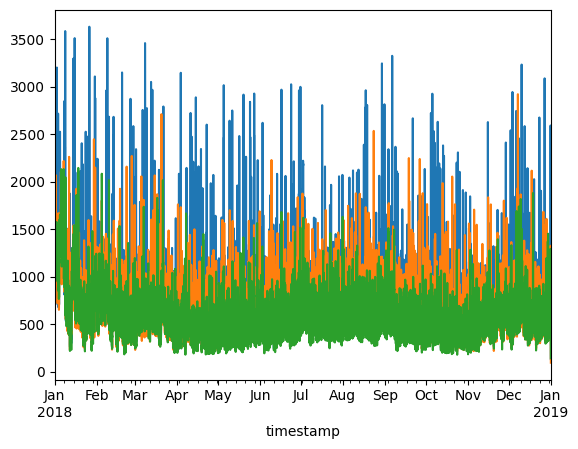

In [ ]:


timestamp_str = str(start_time)

UPGRADE_NUM = 0
STATE = "DC"

random.seed(start_time)

total_merged_buildings_hourly_list = []

if not os.path.exists(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/'):
    os.makedirs(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/')
SAMPLE_RUNS = 3
mean = 1
mu = 0.1
ADJUSTMENT_MULTIPLIER = np.random.normal(mean, mu, size=SAMPLE_RUNS)

ADJUSTMENT_MULTIPLIER_OFF = True

if ADJUSTMENT_MULTIPLIER_OFF:
    ADJUSTMENT_MULTIPLIER = np.ones(SAMPLE_RUNS)

print(ADJUSTMENT_MULTIPLIER)

total_merged_buildings_hourly = pd.DataFrame()

building_characteristics_run_summaries = []


for i in range(0,SAMPLE_RUNS):

    run_value = f'Run-{i+1}'

    resstock_bldg_files = construct_neighborhood_residential()
    comstock_bldg_files = construct_neighborhood_commercial()

    # TODO: Adjust this to save building characteristics along with chosen files

    # chosen_files_df = pd.DataFrame(chosen_files, columns=['filename'])
    # chosen_files_df.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/chosen_files.csv')

    ## TODO Add choices for each run into csv for further analysis.


    # Create a list of DataFrames, one for each file
    df_resstock_list = [pd.read_parquet(os.path.join(INPUT_DATA_DIR_RESSTOCK_BUILDINGPROFILES, f"upgrade={UPGRADE_NUM}/state={STATE}/" + str(resstock_filename) + "-0.parquet")) for resstock_filename in resstock_bldg_files[0]]
    df_comstock_list = [pd.read_parquet(os.path.join(INPUT_DATA_DIR_COMSTOCK_BUILDINGPROFILES, f"upgrade={UPGRADE_NUM}/state={STATE}/" + str(comstock_filename) + "-0.parquet")) for comstock_filename in comstock_bldg_files[0]]

    # Concatenate all DataFrames in the list into a single DataFrame
    resstock_merged_df = pd.concat(df_resstock_list, ignore_index=True)
    comstock_merged_df = pd.concat(df_comstock_list, ignore_index=True)

    resstock_merged_df_w_building_characteristics = pd.merge(resstock_merged_df, building_characteristics[['bldg_id','in.geometry_building_number_units_mf', 'in.geometry_building_type_height']], on='bldg_id', how='left')

    print(f"Resstock Run {i+1}: {resstock_bldg_files}")
    resstock_merged_buildings_15m_w_building_characteristics = resstock_merged_df_w_building_characteristics[['timestamp', 'out.electricity.total.energy_consumption..kwh', 'bldg_id', 'in.sqft', 'in.geometry_building_type_height','in.geometry_building_number_units_mf']]


    #resstock_merged_buildings_15m = resstock_merged_df[['timestamp', 'out.electricity.total.energy_consumption..kwh', 'bldg_id', 'in.sqft','in.geometry_building_type_height','in.geometry_building_number_units_mf']]
    
     
    # Multifamily unit adjustments
    
    resstock_merged_buildings_15m_w_building_characteristics_mf_adjust = resstock_merged_buildings_15m_w_building_characteristics.copy()
    resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh_adjust'] = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh']
    resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.sqft_adjust'] = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.sqft']
        
    # Filter and multiply electricity use by units
    
    resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh_adjust'] = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust[resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.geometry_building_type_height'].isin(MULTIFAMILY_FILTER)]['out.electricity.total.energy_consumption..kwh_adjust'] * resstock_merged_buildings_15m_w_building_characteristics_mf_adjust[resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.geometry_building_type_height'].isin(MULTIFAMILY_FILTER)]['in.geometry_building_number_units_mf']
    resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh_adjust'] = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh_adjust'].fillna(resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh'])
   
    # Filter and multipy ft2 by units

    resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.sqft_adjust'] = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust[resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.geometry_building_type_height'].isin(MULTIFAMILY_FILTER)]['in.sqft_adjust'] * resstock_merged_buildings_15m_w_building_characteristics_mf_adjust[resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.geometry_building_type_height'].isin(MULTIFAMILY_FILTER)]['in.geometry_building_number_units_mf']
    resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.sqft_adjust'] = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.sqft_adjust'].fillna(resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['in.sqft_adjust'])

    #resstock_merged_buildings_15m_w_building_characteristics_mf_adjust[resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh_adjust'].isna()] = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust['out.electricity.total.energy_consumption..kwh_adjust']
    #print(f'With building characteristics mf: ', resstock_merged_buildings_15m_w_building_characteristics_mf_adjust[['timestamp','out.electricity.total.energy_consumption..kwh_adjust']])






    #####################################


    # START OLD CODE WITHOUT ADJUSTMENTS #

    ## Old method
    #    resstock_merged_buildings_15m = resstock_merged_df[['timestamp', 'out.electricity.total.energy_consumption..kwh', 'bldg_id', 'in.sqft']]
    resstock_merged_buildings_15m = resstock_merged_buildings_15m_w_building_characteristics_mf_adjust[['timestamp', 'out.electricity.total.energy_consumption..kwh_adjust', 'bldg_id', 'in.sqft_adjust']]

    resstock_merged_buildings_15m.index = pd.to_datetime(resstock_merged_buildings_15m['timestamp'])

    # Commercial Buildings
    print(f"Comstock Run {i+1}: {comstock_bldg_files}")
    comstock_merged_buildings_15m = comstock_merged_df[['timestamp', 'out.electricity.total.energy_consumption', 'bldg_id']] #, 'in.sqft..ft2']]
    comstock_merged_buildings_15m.index = pd.to_datetime(comstock_merged_buildings_15m['timestamp'])

    #resstock_merged_buildings_hourly = resstock_merged_buildings_15m.resample('h')['out.electricity.total.energy_consumption..kwh'].sum() * ADJUSTMENT_MULTIPLIER[i]
    resstock_merged_buildings_hourly = resstock_merged_buildings_15m.resample('h')['out.electricity.total.energy_consumption..kwh_adjust'].sum() * ADJUSTMENT_MULTIPLIER[i]

    # Old method
    # ax_merged_buildings_hourly = resstock_merged_buildings_hourly.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh')

    ax_merged_buildings_hourly = resstock_merged_buildings_hourly.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh_adjust')
    
    comstock_merged_buildings_hourly = comstock_merged_buildings_15m.resample('h')['out.electricity.total.energy_consumption'].sum() * ADJUSTMENT_MULTIPLIER[i]

    # Resstock hourly
    resstock_merged_buildings_hourly.columns = [f'Resstock Run {i+1}']
    # Old method
    # resstock_merged_buildings_hourly.rename({'out.electricity.total.energy_consumption..kwh': f'Resstock_Run {i+1}'}, inplace=True)
    resstock_merged_buildings_hourly.rename({'out.electricity.total.energy_consumption..kwh_adjust': f'Resstock_Run {i+1}'}, inplace=True)

    # Comstock hourly
    comstock_merged_buildings_hourly.columns = [f'Comstock Run {i+1}']
    comstock_merged_buildings_hourly.rename({'out.electricity.total.energy_consumption': f'Comstock_Run {i+1}'}, inplace=True)

    #total_merged_buildings_hourly = pd.merge(total_merged_buildings_hourly, merged_buildings_hourly, left_index=True, right_index=True, how='inner') #, suffixes=("", "_DROP"))
    #print(total_merged_buildings_hourly.columns)
    #total_merged_buildings_hourly = total_merged_buildings_hourly.filter(regex='^(?!.*_DROP)')

    if not os.path.exists(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/{run_value}/'):
        os.makedirs(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/{run_value}/')

    resstock_merged_buildings_hourly.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/{run_value}/{timestamp_str}_{run_value}_residential_merged_community_load_profile.csv')
    comstock_merged_buildings_hourly.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/{run_value}/{timestamp_str}_Run-{i+1}_comstock_merged_community_load_profile.csv')

    #total_merged_buildings_hourly_list.append(resstock_merged_buildings_hourly)

    total_merged_buildings_hourly = pd.concat([total_merged_buildings_hourly, resstock_merged_buildings_hourly, comstock_merged_buildings_hourly], axis=1)

    total_merged_buildings_hourly.groupby(total_merged_buildings_hourly.index).mean().to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/{run_value}/{timestamp_str}_Run-{i+1}_total_merged_community_load_profile.csv')
    #total_merged_buildings_hourly.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/total_merged_community_load_profile_{timestamp_str}_run-{i+1}.csv')

    #print(resstock_bldg_files[1])

    building_characteristics_run_summaries.append(pd.concat([resstock_run_summary(building_characteristics, resstock_bldg_files), comstock_run_summary(commercial_building_characteristics, comstock_bldg_files)]))
    building_characteristics_run_summaries[i].to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/{run_value}/{timestamp_str}_Run-{i+1}_building_characteristics.csv')

replacement_map = {
    "SmallOffice": "Commercial",
    "PrimarySchool": "Commercial",
    "Outpatient": "Commercial",
    "Warehouse": "Commercial",
    'MediumOffice': "Commercial",
    "Hospital": 'Commercial',
    "SecondarySchool": "Commercial",
}

building_characteristics_run_summaries_total = pd.concat(building_characteristics_run_summaries).reset_index()
building_characteristics_run_summaries_total['building_type'] = building_characteristics_run_summaries_total['building_type'].replace(replacement_map)

building_characteristics_run_summaries_total_output = building_characteristics_run_summaries_total.groupby('building_type').agg(Count=('Count', lambda x: math.ceil(sum(x) / (i+1))), Average_Total_ft2=('Total_ft2','mean')).reset_index()

# with open(os.path.join(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/', f'building_characteristics_total_summary_{timestamp_str}.txt'), 'w') as f:
#     f.write(building_characteristics_run_summaries_total_output.to_string(index=True, header=True))

building_characteristics_run_summaries_total_output.to_csv(os.path.join(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/', f'building_characteristics_total_summary_{timestamp_str}.csv'))

#print("total_merged_buildings_hourly_list: ", total_merged_buildings_hourly) #previously total_merged_buildings_hourly_list

#total_merged_buildings_hourly = pd.concat(total_merged_buildings_hourly_list, axis=0)

#print("total_merged_buildings_hourly: ", total_merged_buildings_hourly)

resstock_total_merged_buildings_hourly_columns_runs = ["Resstock Run " + str(i+1) for i in range(SAMPLE_RUNS)]
comstock_total_merged_buildings_hourly_columns_runs = ["Comstock Run " + str(i+1) for i in range(SAMPLE_RUNS)]

total_merged_buildings_hourly_columns_runs = list(itertools.chain.from_iterable(zip(resstock_total_merged_buildings_hourly_columns_runs, comstock_total_merged_buildings_hourly_columns_runs)))

total_merged_buildings_hourly_columns_runs_total = ["Run " + str(i+1) for i in range(SAMPLE_RUNS)]

#print(total_merged_buildings_hourly_columns_runs)

#total_merged_buildings_hourly_columns = ['timestamp'].extend(total_merged_buildings_hourly_columns_runs)
#print(total_merged_buildings_hourly_columns)

total_merged_buildings_hourly.index.name = 'timestamp'
total_merged_buildings_hourly.columns = total_merged_buildings_hourly_columns_runs

total_merged_buildings_hourly.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/merged_community_load_profile_total_compiled-runs.csv')

#ax_merged_buildings_hourly.get_figure().savefig(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/merged_community_load_profile_total.png')
#plt.close(ax_merged_buildings_hourly.get_figure())

#total_merged_buildings_hourly = pd.concat(total_merged_buildings_hourly, axis=0) # previously total_merged_buildings_hourly_list
#total_merged_buildings_hourly.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/merged_community_load_profile_{timestamp_str}_total.csv')
#print(f"Total Merged Buildings Hourly: ", total_merged_buildings_hourly)
#total_merged_buildings_hourly_average = total_merged_buildings_hourly.groupby(total_merged_buildings_hourly.index).mean()
total_merged_buildings_hourly_average = total_merged_buildings_hourly.mean()
total_merged_buildings_hourly_average["Resstock Average"] = total_merged_buildings_hourly.filter(like="Resstock Run ").mean(axis=0)
total_merged_buildings_hourly_average["Comstock Average"] = total_merged_buildings_hourly.filter(like="Comstock Run ").mean(axis=0)
# print(f"Total Merged Buildings Hourly Average: ", total_merged_buildings_hourly_average)

total_merged_buildings_hourly_average.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/merged_community_load_profile_{timestamp_str}_hourly_average.csv')

# ax_total_merged_buildings_hourly_average = total_merged_buildings_hourly_average.plot(x='timestamp', y='out.electricity.total.energy_consumption..kwh', figsize=(15,5))
# ax_total_merged_buildings_hourly_average.get_figure().savefig(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/merged_community_load_profile_{timestamp_str}_average.png')
# ax_total_merged_buildings_hourly_average.set_title('Average Community Load Profile over ' + str(SAMPLE_RUNS) + ' runs')




In [984]:
end_time = time.time() 

time_diff = end_time - start_time
print(f"Time taken for processing {SAMPLE_RUNS} runs: {time_diff/60.0} minutes")

Time taken for processing 3 runs: 0.4703585147857666 minutes


In [985]:
## Run aggregations

# total_merged_buildings_daily_total = total_merged_buildings_hourly_average.resample('D').sum()
# total_merged_buildings_daily_total.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/merged_community_load_profile_{timestamp_str}_total_daily.csv')
# total_merged_buildings_monthly_total = total_merged_buildings_hourly_average.resample('ME').sum()
# total_merged_buildings_monthly_total.to_csv(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/merged_community_load_profile_{timestamp_str}_total_monthly.csv')

In [986]:
# ## Create Summary File

# workbook = xw.Workbook(f'{OUTPUT_DATA_DIR_SCENARIO_RUNS}{timestamp_str}/output.xlsx')
# worksheet = workbook.add_worksheet('Overview')

# row = 0
# col = 0

# worksheet.write(row, col, 'TimeStart (timestamp)')
# worksheet.write(row+1, col, str(start_time))
# worksheet.write(row, col+1, 'TimeEnd (timestamp)')
# worksheet.write(row+1, col+1, str(end_time))
# worksheet.write(row, col+2, 'TimeDiff (minutes)')
# worksheet.write(row+1, col+2, str(time_diff/60.0))

# workbook.close()

# # # Open the existing file in append mode
# # with pd.ExcelWriter(f'{DIR}{timestamp_str}/output.xlsx', mode='a', engine='openpyxl', if_sheet_exists='new') as writer: